# Modelo de U-Net para procesado masivo de datos

In [0]:
#Importar los módulos
import cv2
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import image as mtpimg
import sys
import os
from pathlib import Path
from skimage import io
from PIL import Image
from tqdm import tqdm

from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, BatchNormalization, Activation, Dense, Dropout, Lambda
from keras.layers.core import Lambda, RepeatVector, Reshape
from tensorflow.keras.layers  import Conv2D, Conv2DTranspose
from tensorflow.keras.layers  import MaxPooling2D, GlobalMaxPool2D
from tensorflow.keras.layers  import concatenate, add
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img


Using TensorFlow backend.


In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Ahora a partir de los directorios vamos a coger las imágenes que tenemos de train y sus correspondientes máscaras:

Definimos la U-Net
![texto alternativo](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png)


In [0]:
# 1) Since each block consicts on two convolutions:

def conv2d_block(input_tensor, n_filters, kernel_size=3, batchnorm=True):
    # first layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    # second layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(x)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x


# 2) We create a function to define the UNET Model
def get_unet(inputs, n_filters=32, dropout=0.5, batchnorm=True):
    # contracting path
    c1 = conv2d_block(inputs, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    p1 = MaxPooling2D((2, 2)) (c1)
    p1 = Dropout(dropout*0.5)(p1)

    c2 = conv2d_block(p1, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)

    c3 = conv2d_block(p2, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)

    c4 = conv2d_block(p3, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters=n_filters*16, kernel_size=3, batchnorm=batchnorm)
    
    # expansive path
    u6 = Conv2DTranspose(n_filters*8, (3, 3), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)

    u7 = Conv2DTranspose(n_filters*4, (3, 3), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)

    u8 = Conv2DTranspose(n_filters*2, (3, 3), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)

    u9 = Conv2DTranspose(n_filters*1, (3, 3), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[inputs], outputs=[outputs])
    return model


In [0]:
gpus = tf.config.experimental.list_physical_devices("GPU")
print("Num GPUs Available: ", len(gpus))

Num GPUs Available:  1


In [0]:
#Ony when using TPU
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
tf.config.experimental_connect_to_cluster(resolver)
# This is the TPU initialization code that has to be at the beginning.
tf.tpu.experimental.initialize_tpu_system(resolver)
strategy = tf.distribute.experimental.TPUStrategy(resolver)

KeyError: ignored

In [0]:
# Specifying the input shape
input_shape = Input((512, 512, 3), dtype = 'float32')

#For the OOM error
run_opts = tf.compat.v1.RunOptions(report_tensor_allocations_upon_oom = True)

model = get_unet(input_shape, n_filters=32, dropout=0.1, batchnorm=True)
model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy"]) #, options = run_opts)
model.summary()
#Cuando sean más cambiar a categorical_crossentropy

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 512, 512, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 512, 512, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 512, 512, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

# Nueva sección

Ahora usamos la función para coger los datos y luego dividir las imágenes y sus máscaras en train y valid

In [0]:
#Loading our data from npy
X_train = np.load('/content/gdrive/My Drive/Numpy/X_train.npy')
y_train_OD= np.load('/content/gdrive/My Drive/Numpy/y_train_OD.npy')
X_test = np.load('/content/gdrive/My Drive/Numpy/X_test.npy')
y_test_OD = np.load('/content/gdrive/My Drive/Numpy/y_test_OD.npy')

In [0]:
print(X_train.shape, y_train_HE.shape,X_test.shape, y_test_HE.shape)
print(np.amin(y_test_HE[30]),np.amax(y_test_HE[192]))
print(np.amin(y_train_HE[50]),np.amax(y_train_HE[300]))

(864, 512, 512, 3) (864, 512, 512, 1) (432, 512, 512, 3) (432, 512, 512, 1)
0.0 1.0
0.0 1.0


0it [00:00, ?it/s]

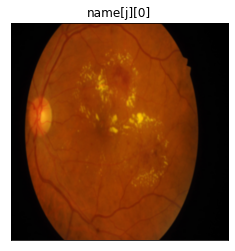

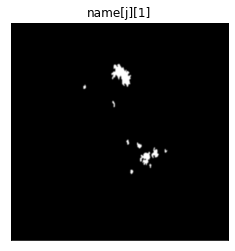

1it [00:00,  2.10it/s]

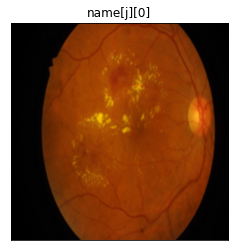

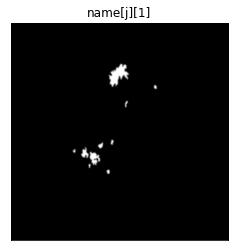

2it [00:00,  2.35it/s]

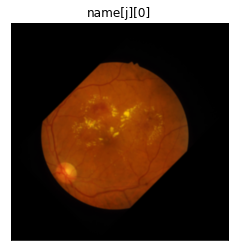

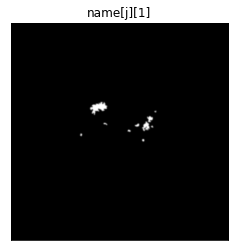

3it [00:01,  2.58it/s]

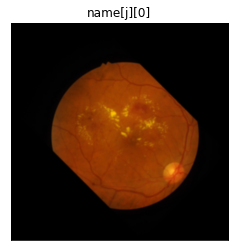

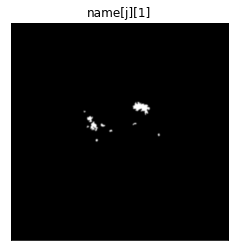

4it [00:01,  2.78it/s]

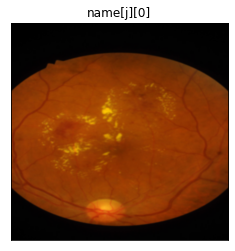

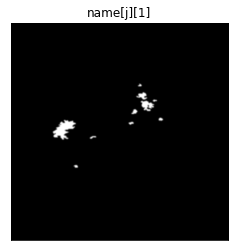

5it [00:01,  2.91it/s]

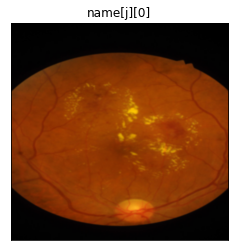

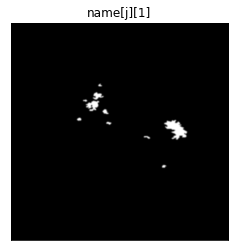

6it [00:01,  3.01it/s]

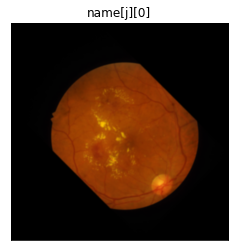

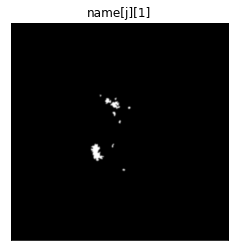

7it [00:02,  3.10it/s]

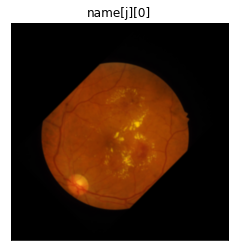

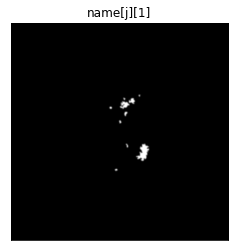

8it [00:02,  3.19it/s]

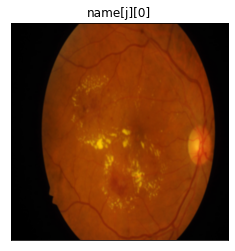

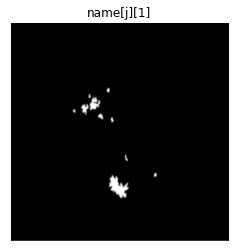

9it [00:02,  3.19it/s]

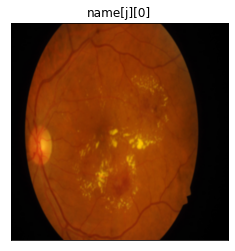

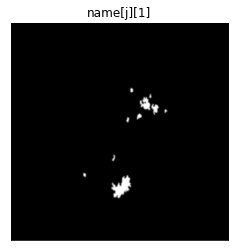

10it [00:03,  3.22it/s]

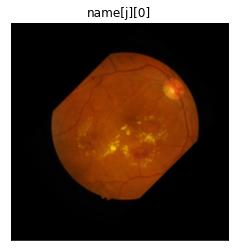

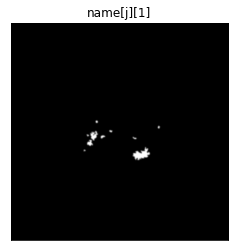

11it [00:03,  3.25it/s]

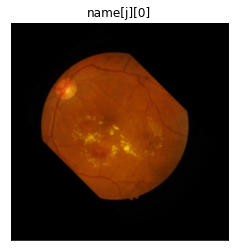

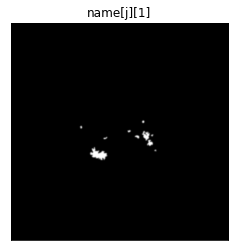

12it [00:03,  3.30it/s]

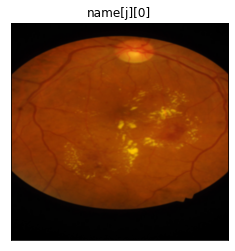

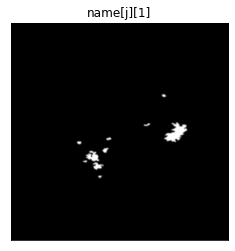

13it [00:04,  3.27it/s]

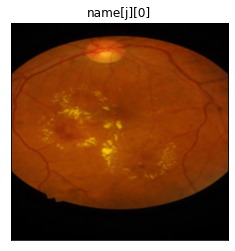

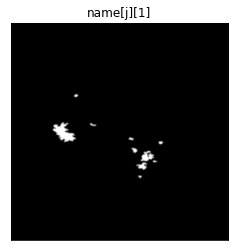

14it [00:04,  3.28it/s]

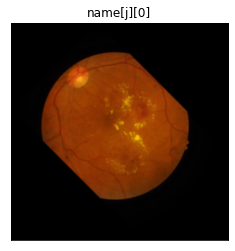

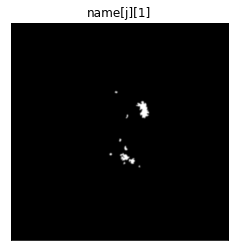

15it [00:04,  3.33it/s]

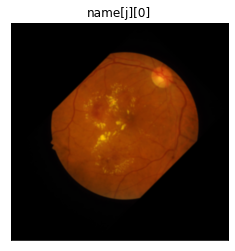

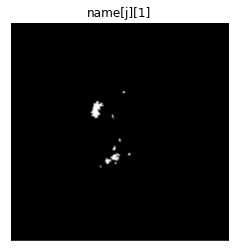

16it [00:04,  3.35it/s]

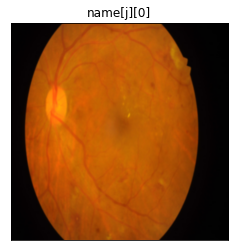

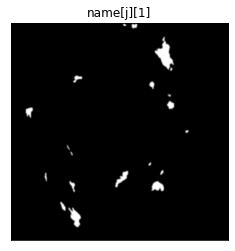

17it [00:05,  3.31it/s]

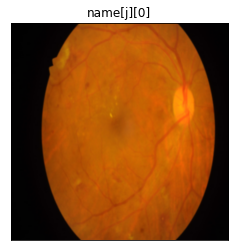

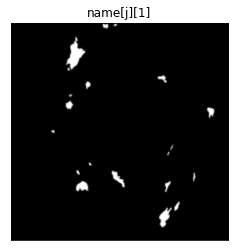

18it [00:05,  3.18it/s]


KeyboardInterrupt: ignored

In [0]:
#Represent the images we obtained:
for j, photo in tqdm(enumerate(X_test)):
    plt.imshow(photo, cmap = 'gray', interpolation = 'bicubic')
    plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
    plt.title('name[j][0]')
    plt.show()

    plt.imshow(y_test_HE[j].squeeze(), cmap = 'gray', interpolation = 'bicubic')
    plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
    plt.title('name[j][1]')
    plt.show()

Ahora ponemos el modelo a entrenarse

In [0]:
#Dividir en X_train, X_valid, y_train, y_valid: NO
#X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=2018)

In [0]:
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
tf.compat.v1.Session(config = config)

In [0]:
#Estas son las callbacks, las definimos para que no se produzca overfitting y underfitting y además se guarde mi modelo.
modelCallbacks = [
    EarlyStopping(monitor = 'val_loss', patience=10, verbose=1),
    ReduceLROnPlateau(monitor = 'val_loss', factor=0.2, patience=6 , min_lr=0.00001, verbose=1),
    ModelCheckpoint('/content/gdrive/My Drive/Registers/OD/model-OD_2.h5', verbose=1, save_best_only=True, save_weights_only=True),
    TensorBoard(log_dir = '/content/gdrive/My Drive/Registers/OD/logs/OD_2')
    ]


results = model.fit(X_train, y_train_OD, batch_size= 16, epochs=100, verbose = 2, callbacks=modelCallbacks, validation_data=(X_test, y_test_OD))



Epoch 1/100

Epoch 00001: val_loss improved from inf to 23.48787, saving model to /content/gdrive/My Drive/Registers/OD/model-OD_2.h5
54/54 - 51s - loss: 0.3200 - accuracy: 0.9402 - val_loss: 23.4879 - val_accuracy: 0.0680 - lr: 0.0010
Epoch 2/100

Epoch 00002: val_loss improved from 23.48787 to 0.53070, saving model to /content/gdrive/My Drive/Registers/OD/model-OD_2.h5
54/54 - 50s - loss: 0.1408 - accuracy: 0.9942 - val_loss: 0.5307 - val_accuracy: 0.9032 - lr: 0.0010
Epoch 3/100

Epoch 00003: val_loss improved from 0.53070 to 0.29859, saving model to /content/gdrive/My Drive/Registers/OD/model-OD_2.h5
54/54 - 50s - loss: 0.0875 - accuracy: 0.9960 - val_loss: 0.2986 - val_accuracy: 0.9714 - lr: 0.0010
Epoch 4/100

Epoch 00004: val_loss did not improve from 0.29859
54/54 - 49s - loss: 0.0588 - accuracy: 0.9965 - val_loss: 0.3311 - val_accuracy: 0.9823 - lr: 0.0010
Epoch 5/100

Epoch 00005: val_loss improved from 0.29859 to 0.06329, saving model to /content/gdrive/My Drive/Registers/OD

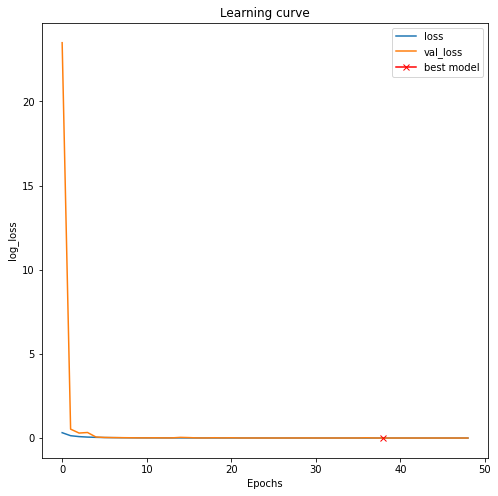

In [0]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

In [0]:
# Now we can load the best model we saved and look at some predictions.
model.load_weights('/content/gdrive/My Drive/Registers/OD/model-OD_2.h5')

# Evaluate on test set (this must be equals to the best log_loss)
model.evaluate(X_test, y_test_OD, verbose=1)

14/14 [==============================] - 6s 416ms/step - loss: 0.0031 - accuracy: 0.9989


[0.0031006329227238894, 0.9988934397697449]

In [0]:
# Predict on train, val and test
preds_train = model.predict(X_train, batch_size= 16, verbose=1)
preds_test = model.predict(X_test, batch_size= 8, verbose=1)



54/54 [==============================] - 7s 132ms/step


In [0]:
#Check the max value from pred train
print(np.amin(preds_test[16]),np.amax(preds_test[16]))

0.00016076288 1.0


In [0]:
# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

In [0]:
def plot_sample(X, y, preds, binary_preds, ix=None):
  plt.imshow(X[ix],cmap='gray')
  plt.xticks([]), plt.yticks([])  
  plt.xlabel('Retina image')
  plt.show()

  plt.imshow(y[ix].squeeze(), cmap='gray',vmin=0,vmax=1)
  plt.xticks([]), plt.yticks([])  
  plt.xlabel('Original mask')
  plt.show()

  plt.imshow(preds[ix].squeeze(), cmap='gray')
  plt.xticks([]), plt.yticks([])  
  plt.xlabel('Mask prediction')
  plt.show()

  plt.imshow(binary_preds[ix].squeeze(), cmap='gray',vmin=0,vmax=1)
  plt.xticks([]), plt.yticks([])  
  plt.xlabel('Binary mask prediction')
  plt.show()





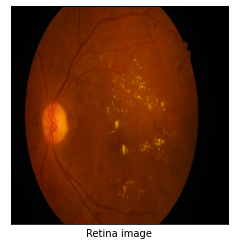

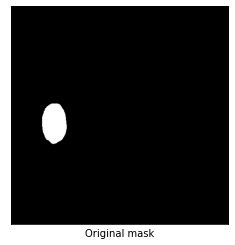

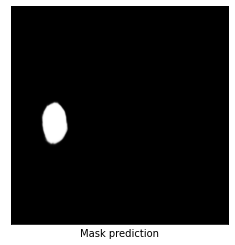

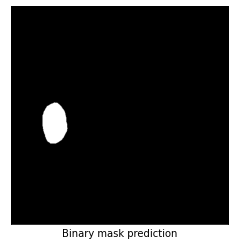

In [0]:
plot_sample(X_train, y_train_OD, preds_train, preds_train_t, ix=160)

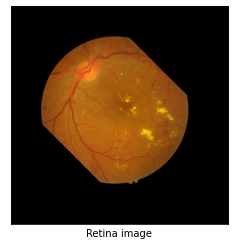

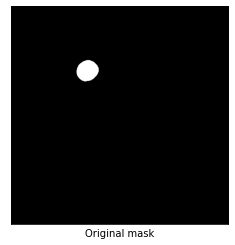

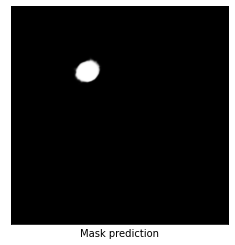

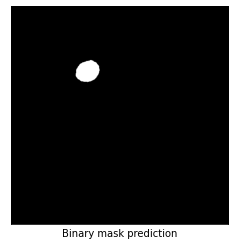

In [0]:
plot_sample(X_test, y_test_OD, preds_test, preds_test_t, ix=395)

In [0]:
print(np.amax(preds_test[200]))


0.00456544


In [0]:
print(len(preds_train))
   for k, filtered in enumerate(photos):
      plt.imshow(filtered,'gray')
      plt.title(titles[k] +' photo filtered image with zero filter')
      plt.xticks([]),plt.yticks([])
      plt.show()

43


In [0]:
#We are going to try to predict with other images:


In [0]:
def get_test_data(path3):
    
    #Como en collab no se me ordenan al igual que en windows lo hago de esta manera.
    
    filesInPathTest = os.listdir(path3)
    imagesTest = np.zeros((len(filesInPathTest), 512, 512, 3), dtype=np.float32)

    for i, filename in tqdm(enumerate(filesInPathTest)):

        imageToRead = path3 + r'/' + str(filename)
        img = img_to_array(mtpimg.imread(imageToRead))/255.0
        img_resiz = resize(img, (512, 512, 3), mode='constant', preserve_range=True)
        if img_resiz is not None:
            imagesTest[i] = img_resiz   

    return imagesTest

In [0]:
testPath = '/content/retina_predict'
Z = get_test_data(testPath)

27it [01:05,  2.43s/it]


In [0]:
# Predict on train, val and test
preds_test = model.predict(Z, batch_size= 16, verbose=1)

# Threshold predictions
preds_test_t = (preds_train > 0.5).astype(np.uint8)

2/2 [==============================] - 0s 197ms/step


In [0]:
plot_sample(Z, y_valid, preds_test, preds_test_t, ix=9)

NameError: ignored